# <center>HW4</center> #
####  107061212 劉亦傑
***

## <u>Question 1_1</u>

### Implementation
* 本次作業要我們使用目前學過的algorithms來分類car dataset，並以Scikit-learn的套件來implement它們。
* 一共有三個小題，以下簡略說明
    1. 把label encode成兩個class，並在使用All features的情況下去train model
    2. 共有四個class，同樣在使用All features的情況下去train model
    3. 一樣是四個class，但要使用feature selection或feature extraction的技巧來處理dataset
* 以下針對第1題進行說明
<br><br>
* 首先先讀進car dataset，並了解dataset的row, columns代表的意涵，會發現是文字類型，於是這邊需要自行將文字encode成數字
* 利用簡單的dict轉換，搭配dataframe的map method就可以成功把dataset轉為數值
* 除此之外，由於題意需要結合unacc, acc為一個label，且good, vgood為另一個label，如此一來就能進行binary classification
* 接著，把兩種label的個數印出來觀察，來看data有沒有不均的問題；會發現到**label 0: 1594個**，而**label 1: 134個**，因此data很明顯有不平均的問題，而上課也學到幾種方法來處理(如resample)，但也有提到處理過後不見得比較好，因此我的設計上先嘗試尚未處理不均的data去選model，看狀況如何再去評估要不要進行resample
* dataset切分的部分與以前作業相同，使用train:test = 7:3的比例來做，但後續會使用k-fold validation的方法來調整model參數
* 下一步就是利用nested k-fold並搭配accuracy, f1_score, precision三種指標來選擇演算法，此題選用了Logistic regression, SVM(Linear, kernel), Decision Tree, KNN來做篩選，並再去畫Learning curves觀察，輸出部分的細節會留到discussion處討論
* 接著就是利用 **grid search** 搭配k fold validation的技巧來找尋參數，這部分由於取決於人為給定的parameters range，通常會是train花費時間最長的一環
* 然後稍微整理這四個演算法有調整到的參數
    * Logistic Regression: 調整C，值給定0.01, 0.1, 1, 10下去跑grid search
    * SVM: 類似於講義，調整kernel為linear or RBF以及調C的值，若是RBF kernel則再調整gamma值
    * Decision Tree: 調整max_depth，須注意這邊有給定None，代表會自行將tree展開到一定層數才結束
    * KNN: 調整n_negihbors的個數
* 可以發現到未經resample的dataset經過上述步驟，已經得到不錯的結果，因此本小題就不額外去做resample，留到後面4種label的題目再去斟酌要不要使用resample處理dataset
* 最後可以選出 **SVM(Kernel RBF)** 當作最終的model，並將test set此時才丟給這項model去評估結果
* 共決定四種不同的指標來評估效能，分別為accuracy, f1_score, precision, recall，並且再搭配畫出confusion matrix來看label最終被分類的情況
* 除此之外，還額外畫上一張ROC AUC的圖，來幫助我們了解ROC AUC的意涵並且觀察看看我所選的model是否表現如預期
* 要注意到畫ROC AUC的時候需要**機率**，而SVM原本的輸出並不是機率，因此要特地設定**probability=True**否則無法成功運作

### Result & Codes

In [1]:
import os
import math
import numpy as np
import pandas as pd
from IPython.display import HTML
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
### Plot the scatter graph to understand the data distribution
def plot_feature(X, y, resolution = 0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                        np.arange(x2_min, x2_max, resolution))
                           
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')        
print('Import necessary modules and define our functions successfully!')

Import necessary modules and define our functions successfully!


In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option("max_rows", None)
title = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class_val']

curr_dir_car = os.getcwd() + '\car.data'
df_car = pd.read_csv(curr_dir_car, header = None)
print('Understand the car.data')

buying_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
maint_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
persons_mapping = {'2': 2, '4': 4, 'more': 5}
doors_mapping = {'2': 2, '3': 3, '4': 4, '5more': 5}
lug_boot_mapping = {'small': 1, 'med': 2, 'big': 3}
safety_mapping = {'low': 1, 'med': 2, 'high': 3}

# unacc, acc -> 0
# good, vgood -> 1
class_val_mapping = {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}


df_car[0] = df_car[0].map(buying_mapping)
df_car[1] = df_car[1].map(maint_mapping)
df_car[2] = df_car[2].map(doors_mapping)
df_car[3] = df_car[3].map(persons_mapping)
df_car[4] = df_car[4].map(lug_boot_mapping)
df_car[5] = df_car[5].map(safety_mapping)
df_car[6] = df_car[6].map(class_val_mapping)
df_car.head(10)

Understand the car.data


,0,1,2,3,4,5,6
0,4,4,2,2,1,1,0
1,4,4,2,2,1,2,0
2,4,4,2,2,1,3,0
3,4,4,2,2,2,1,0
4,4,4,2,2,2,2,0
5,4,4,2,2,2,3,0
6,4,4,2,2,3,1,0
7,4,4,2,2,3,2,0
8,4,4,2,2,3,3,0
9,4,4,2,4,1,1,0


In [3]:
from collections import Counter
print('Realize the distribution of labels')
cnt = Counter(df_car[6])
print(f'label 0: {cnt[0]}')
print(f'label 1: {cnt[1]}')

Realize the distribution of labels
label 0: 1594
label 1: 134


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

X, y = df_car.iloc[:, :-1].values, df_car.iloc[:, -1].values
print('Data has been prepared well!')

Data has been prepared well!


In [5]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)  
print('Data has been split well!')

Data has been split well!


### <font color="purple">Select Algorithms<font>

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
  
print('\nLogistic Regression:\n---------------------')

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=0, solver='lbfgs'))
gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='precision', cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


print('\nSVM:\n---------------------')
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1, probability=True))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},{'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='precision', cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nDecision Tree:\n---------------------')                                      
tree_clf = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='precision', cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nKNN:\n---------------------')                                      
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(p=2, metric='minkowski'))  
param_range_knn = [1, 2, 3, 4, 5, 6, 7]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='precision', cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))



Logistic Regression:
---------------------
CV accuracy: 0.964 +/- 0.003
f1 score: 0.736 +/- 0.063
precision: 0.841 +/- 0.081

SVM:
---------------------
CV accuracy: 0.988 +/- 0.009
f1 score: 0.920 +/- 0.062
precision: 0.922 +/- 0.089

Decision Tree:
---------------------
CV accuracy: 0.983 +/- 0.009
f1 score: 0.895 +/- 0.058
precision: 0.897 +/- 0.091

KNN:
---------------------
CV accuracy: 0.977 +/- 0.009
f1 score: 0.848 +/- 0.056
precision: 0.879 +/- 0.101


### <font color="purple">Find optimal model & draw learning curves<font>


Logistic Regression:
---------------------
Best model score: 0.967
Best model params: {'logisticregression__C': 1}


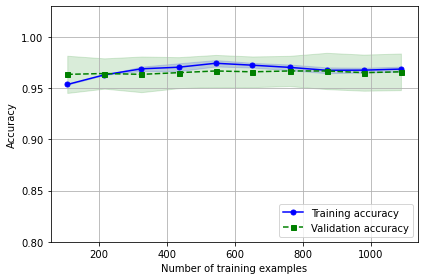


SVM:
---------------------
Best model score: 0.990
Best model params: {'svc__C': 1000.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


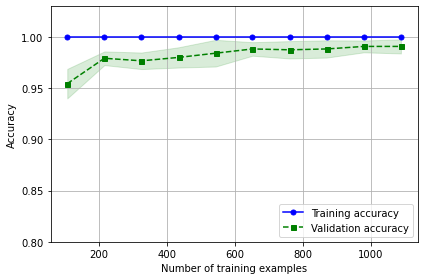


Decision Tree:
---------------------
Best model score: 0.978
Best model params: {'max_depth': None}


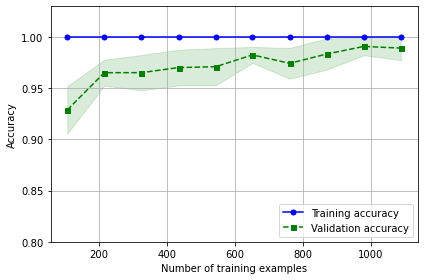


KNN:
---------------------
Best model score: 0.978
Best model params: {'kneighborsclassifier__n_neighbors': 5}


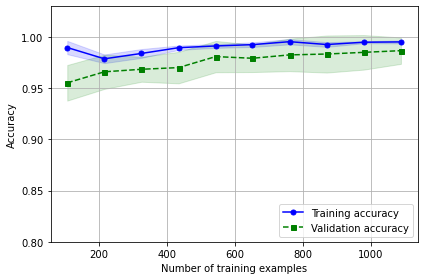

In [7]:
from sklearn.model_selection import learning_curve

L = [pipe_lr, pipe_svc, tree_clf, pipe_knn] # store the algorithm pipeline I choose
clf_lr = None
clf_svm = None
clf_tree = None
clf_knn = None
clf_best = None

for clf in L:
    if clf == pipe_lr:
        print('\nLogistic Regression:\n---------------------')
        gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_lr = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_svc:
        print('\nSVM:\n---------------------')
        gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_svm = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == tree_clf:
        print('\nDecision Tree:\n---------------------')
        gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_tree = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_knn:
        print('\nKNN:\n---------------------')
        gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_knn = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
                                             
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf_best,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='Training accuracy')

    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='Validation accuracy')

    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8, 1.03])
    plt.tight_layout()
    # plt.savefig('images/06_05.png', dpi=300)
    plt.show()
    

### <font color="purple">It looks good enough! So, don't need to resample I think!<font>

### <font color="purple">So, I finally select SVM(Kernel RBF) as my model.<font>

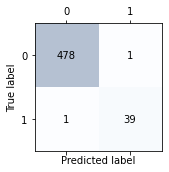

In [8]:
from sklearn.metrics import confusion_matrix

# Use svm as my algorithm with optimal hyperparameters
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Accuracy: 0.996
Precision: 0.975
Recall: 0.975
F1: 0.975


ROC AUC curve: 



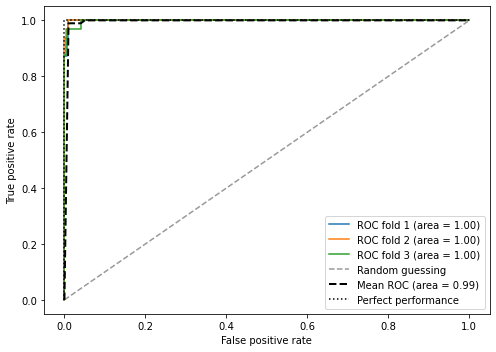

In [10]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version
from sklearn.model_selection import StratifiedKFold

if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp

    
print('ROC AUC curve: \n')
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = clf_svm.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

### Discussion

由於一開始拿到此dataset，將其分為兩類label之後，把label數印出就發現到dataset分布相當不均<br>
而課堂上有提到解決分布不均的方法，可以使用resample的技巧來處理，但並不是一個保證有效的技巧<br>
因此我的設計是，在未進行resample處理的時候先丟入我設定的nested k-fold validation來選擇演算法，看看各項效能指標在validation set上的表現<br>

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
CV Accuracy    | 0.964 +/- 0.003                  | 0.988 +/- 0.009 |   0.983 +/- 0.009       | 0.977 +/- 0.009 |
f1_score    |0.736 +/- 0.063                         | 0.920 +/- 0.062 |  0.895 +/- 0.058       | 0.848 +/- 0.056 |
Precision    | 0.841 +/- 0.081                        | 0.922 +/- 0.089 |   0.897 +/- 0.091     | 0.879 +/- 0.101 | 

上表是validation的各項指標整理<br>
可以觀察到SVM, decision tree, KNN的效能在初步未仔細調參的時候已經十分不錯，因此本題就不再去特地做resample處理<br>
接著便是利用grid search來找參數，單看表格，可以說選擇SVM做為拿來評估的model較合適<br>
但為了觀察overfitting的狀況，會再加入learning curve來討論<br>
可以發現到除了logistic regression外，其他三者整體表現相當接近，收斂狀況也不錯<br>
於是決定利用grid search找出的最優參數的best score來選擇model<br>

下表為best score的整理<br>

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
Best_model_score    |   0.967                  | 0.990 |  0.978       | 0.978  |

綜上所述，最後選擇**SVM(RBF, C=1000, gamma=0.1)作為model來評估** 

下面將針對我使用的演算法(即Kernel SVM)，搭配一些評分指標(如confusion matrix, ROC AUC curve)來探討model的performance

Algorithms |  SVM(Kernel RBF) | 
--------------|:----------------------------:|
Accuracy    | 99.6%                         |
Precision    | 97.5%                |
Recall   | 97.5%                       |
f1_score    | 97.5%                  |    

根據上表可以發現到，accuracy已經近乎完美地達到了99.6%，而Precision, Recall的值恰好相等，也就意味著綜觀表示的f1_score也為97.5%，整體model的performance已經達到很好的水準<br>
接著觀察confusion matrix，會發現兩個label各只有一個sample被誤判，其餘皆為正確，也說明了為何Precision, Recall會相等(根據它們的定義，若FN, FP相等，precision, recall就兩者相等)<br>
最後，檢查看看ROC AUC curve，可以發現到幾乎是一個理想的狀態，已經與perfect performance十分接近，代表model的表現是相當滿意的

## <u>Question 1_2</u>

### Implementation
* 第2題題意要求我們建立一個model來辨別4個label，而與前一題的一開始的差異在於label編碼的時候
* 前一題是編成0與1 (binary classification)，但這邊則是multi-class的形式，要將unacc, acc, good, vgood分別編碼為一種label
* 接著，把label的個數印出來觀察，來看data有沒有不均的問題；會發現到**label 0: 1210個**, **label 1: 384個**, **label 2: 69個**, **label 3: 65個**
* 相較於前一題，儘管這題分為四個class，data依然存在明顯不平均的問題，而這題的設計上，在選演算法的階段決定把「有resample的case」和「沒有resample的case」都跑一次，再從兩者擇優來選擇model
* 要注意的是，**resample時需要先切完之後，以training set來做**，否則會讓model提前看到test的資訊，如此一來model會變得特別準，而導致generalization errror較高
* dataset切分同樣使用train:test = 7:3的比例來做，後續會使用k-fold validation的方法來調整model參數
* 下一步與前一題類似，選用了Logistic regression, SVM(Linear, kernel), Decision Tree, KNN來做篩選，加上利用nested k-fold並搭配accuracy, f1_score, precision三種指標來取捨
* 但這邊在給予score的時候，像是f1_score, precision這些指標，由於是multi-class的緣故，所以需要指定要使用**Micro**還是**Macro**來評分，在我的設計中一律固定使用**Marco**，方便討論
* 同樣地會再去畫Learning curves觀察overfitting狀況，輸出的狀況會再discussion更詳細討論
* 最後經由neste k-fold去選可以選出 **SVM(Kernel RBF)** 當作最終的model，並將test set此時才丟給這項model去評估結果
* 共決定四種不同的指標來評估效能，分別為accuracy, f1_score, precision, recall，並且再搭配畫出confusion matrix來看label最終被分類的情況

### Result & Codes

In [11]:
# pd.set_option('display.max_columns', None)
# pd.set_option("max_rows", None)
title = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class_val']

curr_dir_car = os.getcwd() + '\car.data'
df_car = pd.read_csv(curr_dir_car, header = None)
print('Understand the car.data')

buying_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
maint_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
persons_mapping = {'2': 2, '4': 4, 'more': 5}
doors_mapping = {'2': 2, '3': 3, '4': 4, '5more': 5}
lug_boot_mapping = {'small': 1, 'med': 2, 'big': 3}
safety_mapping = {'low': 1, 'med': 2, 'high': 3}

# unacc, acc, good, vgood ->0, 1, 2, 3
class_val_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}


df_car[0] = df_car[0].map(buying_mapping)
df_car[1] = df_car[1].map(maint_mapping)
df_car[2] = df_car[2].map(doors_mapping)
df_car[3] = df_car[3].map(persons_mapping)
df_car[4] = df_car[4].map(lug_boot_mapping)
df_car[5] = df_car[5].map(safety_mapping)
df_car[6] = df_car[6].map(class_val_mapping)
df_car.head(10)

Understand the car.data


,0,1,2,3,4,5,6
0,4,4,2,2,1,1,0
1,4,4,2,2,1,2,0
2,4,4,2,2,1,3,0
3,4,4,2,2,2,1,0
4,4,4,2,2,2,2,0
5,4,4,2,2,2,3,0
6,4,4,2,2,3,1,0
7,4,4,2,2,3,2,0
8,4,4,2,2,3,3,0
9,4,4,2,4,1,1,0


In [12]:
print('Realize the distribution of num of labels!')
cnt = Counter(df_car[6])
print(f'label 0: {cnt[0]}')
print(f'label 1: {cnt[1]}')
print(f'label 2: {cnt[2]}')
print(f'label 3: {cnt[3]}')

Realize the distribution of num of labels!
label 0: 1210
label 1: 384
label 2: 69
label 3: 65


In [13]:
X, y = df_car.iloc[:, :-1].values, df_car.iloc[:, -1].values
print('Data has been prepared well!')

Data has been prepared well!


In [14]:
# Split data
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
print('Data has been split well!')

Data has been split well!


In [15]:
from sklearn.metrics import make_scorer


# define marco_precision
pre_scorer = make_scorer(score_func=precision_score, 
                         greater_is_better=True, 
                         average='macro')

print('\nLogistic Regrssion:\n---------------------')

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=0, solver='lbfgs'))
gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


print('\nSVM:\n---------------------')
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},{'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nDecision Tree:\n---------------------')                                      
tree_clf = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
print('\nKNN:\n---------------------')                                      
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(p=2, metric='minkowski'))  
param_range_knn = [1, 2, 3, 4, 5, 6, 7]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
                                      


Logistic Regrssion:
---------------------
CV accuracy: 0.850 +/- 0.016
f1 score: 0.740 +/- 0.044
precision: 0.770 +/- 0.052

SVM:
---------------------
CV accuracy: 0.977 +/- 0.012
f1 score: 0.952 +/- 0.021
precision: 0.960 +/- 0.015

Decision Tree:
---------------------
CV accuracy: 0.961 +/- 0.006
f1 score: 0.907 +/- 0.027
precision: 0.917 +/- 0.027

KNN:
---------------------
CV accuracy: 0.950 +/- 0.014
f1 score: 0.903 +/- 0.027
precision: 0.915 +/- 0.026


### <font color="purple">Above cell doesn't use resample yet. So, try resampling below!  <font>

In [16]:
from sklearn.utils import resample

# upsampling
# Since the dataset is imbalanced (class 0 has the most), up-sampling can increase the samples in class 1, 2, 3
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])
print('Number of class 2 examples before:', X_train[y_train == 2].shape[0])
print('Number of class 3 examples before:', X_train[y_train == 3].shape[0])


X_upsampled_1, y_upsampled_1 = resample(X_train[y_train == 1],
                                    y_train[y_train == 1],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)
X_upsampled_2, y_upsampled_2 = resample(X_train[y_train == 2],
                                    y_train[y_train == 2],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)
X_upsampled_3, y_upsampled_3 = resample(X_train[y_train == 3],
                                    y_train[y_train == 3],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled_1.shape[0])
print('Number of class 2 examples after:', X_upsampled_2.shape[0])
print('Number of class 3 examples after:', X_upsampled_3.shape[0])
X_train = np.vstack((X_train[y_train == 0], X_upsampled_1, X_upsampled_2, X_upsampled_3))
y_train = np.hstack((y_train[y_train == 0], y_upsampled_1, y_upsampled_2, y_upsampled_3))

Number of class 1 examples before: 269
Number of class 2 examples before: 48
Number of class 3 examples before: 45
Number of class 1 examples after: 847
Number of class 2 examples after: 847
Number of class 3 examples after: 847


In [17]:
from sklearn.metrics import make_scorer


# define marco_precision
pre_scorer = make_scorer(score_func=precision_score, 
                         greater_is_better=True, 
                         average='macro')

print('\nLogistic Regrssion:\n---------------------')

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=0, solver='lbfgs'))
gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


print('\nSVM:\n---------------------')
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},{'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nDecision Tree:\n---------------------')                                      
tree_clf = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
print('\nKNN:\n---------------------')                                      
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(p=2, metric='minkowski'))  
param_range_knn = [1, 2, 3, 4, 5, 6, 7]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
                                      


Logistic Regrssion:
---------------------
CV accuracy: 0.885 +/- 0.013
f1 score: 0.883 +/- 0.014
precision: 0.883 +/- 0.014

SVM:
---------------------
CV accuracy: 0.995 +/- 0.001
f1 score: 0.995 +/- 0.001
precision: 0.995 +/- 0.001

Decision Tree:
---------------------
CV accuracy: 0.996 +/- 0.002
f1 score: 0.996 +/- 0.002
precision: 0.996 +/- 0.002

KNN:
---------------------
CV accuracy: 0.986 +/- 0.004
f1 score: 0.986 +/- 0.004
precision: 0.986 +/- 0.003


### <font color="purple">It looks better than "No resample" case. So, I choose to use "resample" in my design!<font>

### <font color="purple">Find optimal model & draw learning curves<font>


Logistic Regression:
---------------------
Best model score: 0.879
Best model params: {'logisticregression__C': 10}


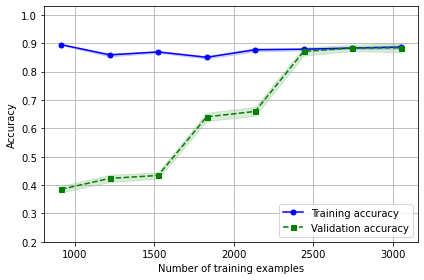


SVM:
---------------------
Best model score: 0.997
Best model params: {'svc__C': 100.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


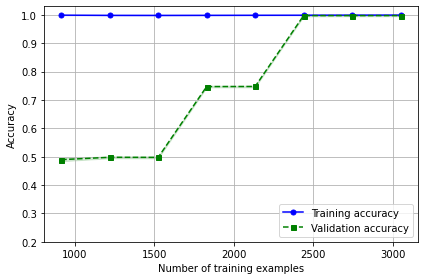


Decision Tree:
---------------------
Best model score: 0.992
Best model params: {'max_depth': None}


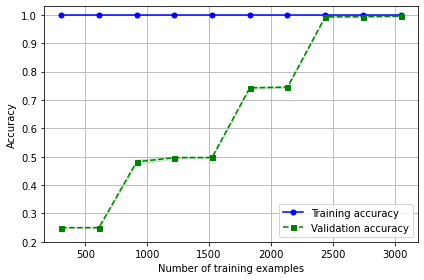


KNN:
---------------------
Best model score: 0.981
Best model params: {'kneighborsclassifier__n_neighbors': 2}


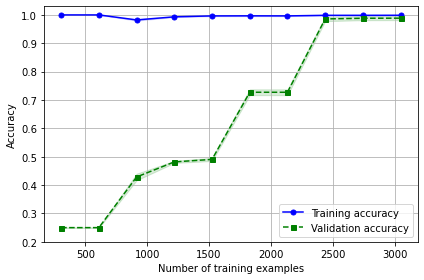

In [18]:
L = [pipe_lr, pipe_svc, tree_clf, pipe_knn]

clf_lr = None
clf_svm = None
clf_tree = None
clf_knn = None
clf_best = None

for clf in L:
    if clf == pipe_lr:
        print('\nLogistic Regression:\n---------------------')
        gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_lr = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_svc:
        print('\nSVM:\n---------------------')
        gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_svm = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == tree_clf:
        print('\nDecision Tree:\n---------------------')
        gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_tree = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_knn:
        print('\nKNN:\n---------------------')
        gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train, y_train)
        clf_best = gs.best_estimator_
        clf_knn = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
        
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf_best,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='Training accuracy')

    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='Validation accuracy')

    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.2, 1.03])
    plt.tight_layout()
    # plt.savefig('images/06_05.png', dpi=300)
    plt.show()

### <font color="purple">So, I finally select SVM(Kernel RBF) as my model.<font>

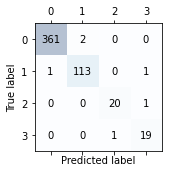

In [19]:
from sklearn.metrics import confusion_matrix

clf_svm.fit(X_train, y_train) # select SVM for using
y_pred = clf_svm.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

Accuracy: 0.988
Precision: 0.959
Recall: 0.970
F1: 0.964


### Discussion

與前一題同樣的dataset，差別只在label encode的方式，同樣把label數印出來就發現到dataset分布依然很不均<br>
故本題設計上決定分兩個case來做<br>
未進行resample處理的data以及有進行resample處理的data，分別都會丟入我設定的nested k-fold validation來選擇演算法，看看各項效能指標在validation set上的表現，來去抉擇究竟是否要使用resample<br>
下表是validation的各項指標整理，在**沒使用resample**的情況<br>

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
CV Accuracy    | 0.850 +/- 0.016                 | 0.977 +/- 0.012 |   0.961 +/- 0.006       | 0.950 +/- 0.014 |
f1_score    |0.740 +/- 0.044                         | 0.952 +/- 0.021 |  0.907 +/- 0.027    |  0.903 +/- 0.027 |
Precision    | 0.770 +/- 0.052                      |  0.960 +/- 0.015 |   0.917 +/- 0.027 | 0.915 +/- 0.026 | 

下表則是validation的各項指標整理，在**有使用resample**的情況

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
CV Accuracy    | 0.885 +/- 0.013                       | 0.995 +/- 0.001 |   0.996 +/- 0.002       | 0.986 +/- 0.004 |
f1_score    |0.883 +/- 0.014                         | 0.995 +/- 0.001 |   0.996 +/- 0.002      | 0.986 +/- 0.004 |
Precision    |  0.883 +/- 0.014                      | 0.995 +/- 0.001 |   0.996 +/- 0.002       | 0.986 +/- 0.003 | 

由上面兩張表格可以更加確認選擇 **使用resample** 在這題的實作中是有幫助的<br>
接著便是利用grid search來找參數，單看表格，可以說選擇SVM做為拿來評估的model較合適<br>
但為了觀察overfitting的狀況，再加入learning curve來討論<br>
首先，logistic regression明顯表現不如其他演算法，因此不考慮；剩餘三者演算法在learning curve上在最後的表現都是不錯的，training和validation有收斂到一起，代表overfitting現象並不明顯，也間接說明了繼續增加data對model幫助也不大了<br>
而為了從這三者演算法中選取較適合的，決定從grid search找出最佳參數後再用best score來權衡<br><br>
下表為best score的整理<br>

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
Best_model_score    |       0.879              | 0.997 |   0.992       |0.981 |

因此，根據上表結果，我**最終選擇SVM(RBF, C=100, gamma=0.1)作為model來評估** 

綜合上述結果，以下將藉由幾項指標搭配confusion matrix，對我使用的演算法(Kernel SVM)來探討model的performance<br>

Algorithms |  SVM(Kernel RBF) | 
--------------|:----------------------------:|
Accuracy    | 98.8%                         |
Precision    | 95.9%                |
Recall   | 97.0%                       |
f1_score    | 96.4%                  |    

根據confusion matrix的結果，可以發現左斜對角線上落著大部分的sample，也就是說多數都是被判斷正確的，僅有少數幾個sample (< 10個)被判斷錯誤，整體而言十分理想<br>
根據上表可以發現accuracy最高，達到了98.8%是相對理想的值；而比較precision和recall的值，會發現到recall稍高一點，代表說我的model是相對寬鬆的，儘管有時候會誤判，但較不會有漏掉沒抓到的情形。不過，這兩者的值都達到了95%以上，因此我認為已經在這題的分類下能夠達到相當不錯的水平了<br>
從最後一項指標f1_score來綜觀這個model，也具有96.4%的值，整體而言對這項dataset來說是個有足夠水準的model<br>

從computational complexity的角度來討論，我認為在grid search的時候似乎可以去花更多時間精確優化cv的個數，如此一來在運算上會建出比較少個數的model，以節省資源<br>
而若要更直接的去減少計算量，那就需要應用到下一題的feature selection或feature extraction<br>
除此之外，由於我最後使用的model是RBF kernel的SVM，也就是non-linear的SVM，這種演算法也會比Linear SVM來得相對消耗運算量，或許能夠使用看看KNN或decision tree，藉由幾乎沒有太大差別的效能犧牲，來換取運算量的減少<br>

實際training的時間上，在grid search SVM的時候會耗費最長時間，原因應該是SVM本身可調的參數就多(kernel, C, gamma)；而相對來說，KNN和decision tree所花費的時間較短，而這兩者相差並不大，主要花的時間應該跟neighbors個數(KNN), max_depth(decision tree)有極大關聯

## <u>Question 1_3</u>

### Implementation
* 第3題與第2題幾乎一樣，差別僅在於要求我們使用feature selection或feature extraction技巧來減少運算量，並討論看看運算量減低與效能的trade off
* 這題我的設計會先印出feature importance，並且嘗試取幾個較重要的feature直接拿進去training，好處是能直接減少運算量，但從cross validation的結果來看似乎犧牲不少精準度，原因推測是總共僅有6個feature，而彼此的重要性也沒有到差距非常大的緣故
* 因此，便不考慮使用feature selection來train model
* 接著便是利用PCA & LDA來處理看看feature<br>
* 先嘗試PCA，設定上讓PCA的component設定為**3**，因為取2個似乎稍嫌不足，而取太多又失去了要減少運算量的初衷
* 要注意的是，原本的設計上是使用pipeline，其中已經包含了數據標準化的處理，但要做PCA的話就需要獨立開來比較好處理，因此在PCA前要先準備好標準化的數據供某些演算法使用
* 做完PCA處理後，利用課本所教的explained variance ratio來觀察，可以發現到設定3個component的話能得到將近70%的ratio，換句話說若使用2個則的確有太少的可能
* 最後畫出learning curve可以發現PCA中，其實已經有model表現不錯了，但依然嘗試看看LDA的效果，因為LDA會再多留下label information，或許能對model效能更有所提升，之後再去看說要用哪種方法train出的model來評估結果
* 類似於PCA的處理，去嘗試LDA後會發現，無論是validation時的各項分數(precision, f1_score)，或是grid search完後model的表現都比PCA還來得略優，因此決定使用LDA方法產生的model來進行評估
* 值得注意的地方是LDA的explained variance ratio，在跟PCA同樣3個component時，得到了比PCA高許多的ratio，似乎也間接說明了為何LDA表現比PCA優
* 最後可以選出 **KNN** 當作最終的model，並將test set此時才丟給這model去評估結果 (**於discussion會更詳細討論結果**)
* 共決定四種不同的指標來評估效能，分別為accuracy, f1_score, precision, recall，並且再搭配畫出confusion matrix來看label最終被分類的情況

### Result & Codes

In [21]:
# pd.set_option('display.max_columns', None)
# pd.set_option("max_rows", None)

curr_dir_car = os.getcwd() + '\car.data'
df_car = pd.read_csv(curr_dir_car, header = None)
print('Understand the car.data')

buying_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
maint_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
persons_mapping = {'2': 2, '4': 4, 'more': 5}
doors_mapping = {'2': 2, '3': 3, '4': 4, '5more': 5}
lug_boot_mapping = {'small': 1, 'med': 2, 'big': 3}
safety_mapping = {'low': 1, 'med': 2, 'high': 3}

# unacc, acc, good, vgood ->0, 1, 2, 3
class_val_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}


df_car[0] = df_car[0].map(buying_mapping)
df_car[1] = df_car[1].map(maint_mapping)
df_car[2] = df_car[2].map(doors_mapping)
df_car[3] = df_car[3].map(persons_mapping)
df_car[4] = df_car[4].map(lug_boot_mapping)
df_car[5] = df_car[5].map(safety_mapping)
df_car[6] = df_car[6].map(class_val_mapping)
df_car.head(10)

Understand the car.data


,0,1,2,3,4,5,6
0,4,4,2,2,1,1,0
1,4,4,2,2,1,2,0
2,4,4,2,2,1,3,0
3,4,4,2,2,2,1,0
4,4,4,2,2,2,2,0
5,4,4,2,2,2,3,0
6,4,4,2,2,3,1,0
7,4,4,2,2,3,2,0
8,4,4,2,2,3,3,0
9,4,4,2,4,1,1,0


In [22]:
X, y = df_car.iloc[:, :-1].values, df_car.iloc[:, -1].values
print('Data has been prepared well!')

Data has been prepared well!


In [23]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
print('Data has been split well!')

Data has been split well!


In [24]:
# upsampling
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])
print('Number of class 2 examples before:', X_train[y_train == 2].shape[0])
print('Number of class 3 examples before:', X_train[y_train == 3].shape[0])


X_upsampled_1, y_upsampled_1 = resample(X_train[y_train == 1],
                                    y_train[y_train == 1],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)
X_upsampled_2, y_upsampled_2 = resample(X_train[y_train == 2],
                                    y_train[y_train == 2],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)
X_upsampled_3, y_upsampled_3 = resample(X_train[y_train == 3],
                                    y_train[y_train == 3],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled_1.shape[0])
print('Number of class 2 examples after:', X_upsampled_2.shape[0])
print('Number of class 3 examples after:', X_upsampled_3.shape[0])
X_train = np.vstack((X_train[y_train == 0], X_upsampled_1, X_upsampled_2, X_upsampled_3))
y_train = np.hstack((y_train[y_train == 0], y_upsampled_1, y_upsampled_2, y_upsampled_3))

Number of class 1 examples before: 269
Number of class 2 examples before: 48
Number of class 3 examples before: 45
Number of class 1 examples after: 847
Number of class 2 examples after: 847
Number of class 3 examples after: 847


Find the feature importance!

 1) safety                         0.294554
 2) buying                         0.201960
 3) maint                          0.173157
 4) lug_boot                       0.144096
 5) persons                        0.139814
 6) doors                          0.046419


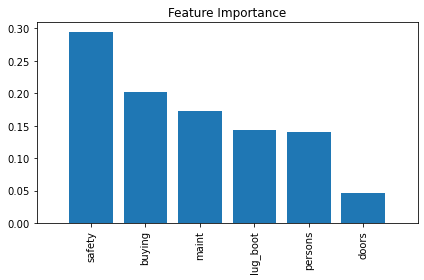

In [25]:
from sklearn.ensemble import RandomForestClassifier

print('Find the feature importance!\n')
feat_labels = df_car.columns[:-1]
title = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

label = []
for idx in indices:
    label.append(title[idx])

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            title[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]), 
           label, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()


In [26]:
X_train_sel = X_train[:, [0, 1, 5]]
X_test_sel = X_test[:, [0, 1, 5]]
print('Try to select top 3 important features')

Try to select top 3 important features


### <font color="purple">Select Algorithms (feature selection)<font>

In [27]:
from sklearn.metrics import make_scorer


# define marco_precision
pre_scorer = make_scorer(score_func=precision_score, 
                         greater_is_better=True, 
                         average='macro')

print('\nLogistic Regrssion:\n---------------------')

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=0, solver='lbfgs'))
gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


print('\nSVM:\n---------------------')
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},{'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nDecision Tree:\n---------------------')                                      
tree_clf = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
print('\nKNN:\n---------------------')                                      
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(p=2, metric='minkowski'))  
param_range_knn = [1, 2, 3, 4, 5, 6, 7]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_sel, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
                                      


Logistic Regrssion:
---------------------
CV accuracy: 0.736 +/- 0.015
f1 score: 0.730 +/- 0.016
precision: 0.749 +/- 0.016

SVM:
---------------------
CV accuracy: 0.785 +/- 0.016
f1 score: 0.783 +/- 0.018
precision: 0.809 +/- 0.008

Decision Tree:
---------------------
CV accuracy: 0.792 +/- 0.009
f1 score: 0.792 +/- 0.009
precision: 0.808 +/- 0.007

KNN:
---------------------
CV accuracy: 0.646 +/- 0.047
f1 score: 0.618 +/- 0.066
precision: 0.628 +/- 0.068


### <font color="purple">No good... So, try PCA instead!<font>

In [28]:
# Standardize data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
print('Data has been standardized')

Data has been standardized


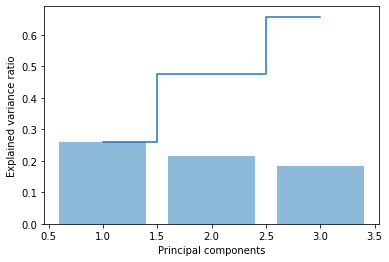

In [29]:
from sklearn.decomposition import PCA

n_comp = 3

pca = PCA(n_components=n_comp)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_train_pca_no_std = pca.fit_transform(X_train)
X_test_pca_no_std = pca.transform(X_test)

plt.bar(range(1, n_comp + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, n_comp + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

### <font color="purple">Select Algorithms (PCA)<font>

In [30]:
# define marco_precision
pre_scorer = make_scorer(score_func=precision_score, 
                         greater_is_better=True, 
                         average='macro')

print('\nLogistic Regression:\n---------------------')

pipe_lr = make_pipeline(LogisticRegression(random_state=0, solver='lbfgs'))
gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


print('\nSVM:\n---------------------')
pipe_svc = make_pipeline(SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},{'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nDecision Tree:\n---------------------')                                      
tree_clf = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train_pca_no_std, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_pca_no_std, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_pca_no_std, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nKNN:\n---------------------')                                      
pipe_knn = make_pipeline(KNeighborsClassifier(p=2, metric='minkowski'))  
param_range_knn = [1, 2, 3, 4, 5, 6, 7]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))



Logistic Regression:
---------------------
CV accuracy: 0.710 +/- 0.018
f1 score: 0.711 +/- 0.019
precision: 0.712 +/- 0.021

SVM:
---------------------
CV accuracy: 0.981 +/- 0.007
f1 score: 0.981 +/- 0.007
precision: 0.983 +/- 0.006

Decision Tree:
---------------------
CV accuracy: 0.937 +/- 0.010
f1 score: 0.936 +/- 0.010
precision: 0.941 +/- 0.010

KNN:
---------------------
CV accuracy: 0.946 +/- 0.006
f1 score: 0.946 +/- 0.006
precision: 0.949 +/- 0.006


### <font color="purple">Find optimal model & draw learning curves<font>


Logistic Regression:
---------------------
Best model score: 0.707
Best model params: {'logisticregression__C': 0.1}


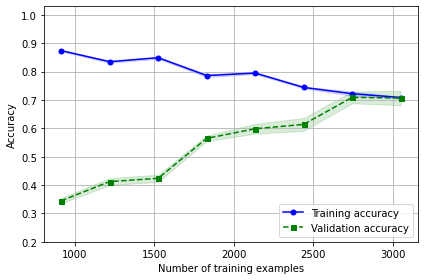


SVM:
---------------------
Best model score: 0.981
Best model params: {'svc__C': 1.0, 'svc__gamma': 1000.0, 'svc__kernel': 'rbf'}


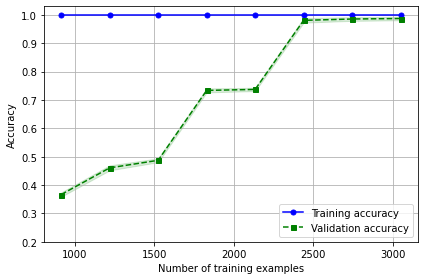


Decision Tree:
---------------------
Best model score: 0.921
Best model params: {'max_depth': None}


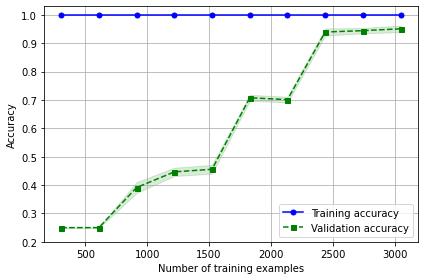


KNN:
---------------------
Best model score: 0.928
Best model params: {'kneighborsclassifier__n_neighbors': 1}


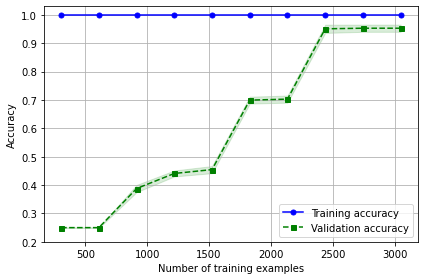

In [31]:
L = [pipe_lr, pipe_svc, tree_clf, pipe_knn]

clf_lr = None
clf_svm = None
clf_tree = None
clf_knn = None
clf_best = None

for clf in L:
    if clf == pipe_lr:
        print('\nLogistic Regression:\n---------------------')
        gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
        gs = gs.fit(X_train_pca, y_train)
        clf_best = gs.best_estimator_
        clf_lr = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_svc:
        print('\nSVM:\n---------------------')
        gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
        gs = gs.fit(X_train_pca, y_train)
        clf_best = gs.best_estimator_
        clf_svm = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == tree_clf:
        print('\nDecision Tree:\n---------------------')
        gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train_pca_no_std, y_train)
        clf_best = gs.best_estimator_
        clf_tree = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_knn:
        print('\nKNN:\n---------------------')
        gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train_pca, y_train)
        clf_best = gs.best_estimator_
        clf_knn = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
        
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf_best,
                                X=X_train_pca,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=-1)
    # since decision tree NO need standardization!
    if clf == tree_clf:
        train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf_best,
                                X=X_train_pca_no_std,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=-1)
        

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='Training accuracy')

    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='Validation accuracy')

    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.2, 1.03])
    plt.tight_layout()
    # plt.savefig('images/06_05.png', dpi=300)
    plt.show()

### <font color="purple">Though it's good, I still try LDA in the following cells.<font>

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

n_comp = 3

lda = LDA(n_components=n_comp)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

X_train_lda_no_std = lda.fit_transform(X_train, y_train)
X_test_lda_no_std = lda.transform(X_test)

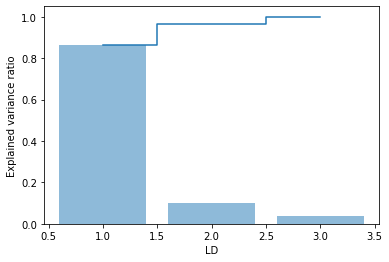

In [33]:
plt.bar(range(1, n_comp + 1), lda.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, n_comp + 1), np.cumsum(lda.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('LD')

plt.show()

In [34]:
# define marco_precision
pre_scorer = make_scorer(score_func=precision_score, 
                         greater_is_better=True, 
                         average='macro')

print('\nLogistic Regression:\n---------------------')

pipe_lr = make_pipeline(LogisticRegression(random_state=0, solver='lbfgs'))
gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


print('\nSVM:\n---------------------')
pipe_svc = make_pipeline(SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},{'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nDecision Tree:\n---------------------')                                      
tree_clf = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train_lda_no_std, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_lda_no_std, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_lda_no_std, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('\nKNN:\n---------------------')                                      
pipe_knn = make_pipeline(KNeighborsClassifier(p=2, metric='minkowski'))  
param_range_knn = [1, 2, 3, 4, 5, 6, 7]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring='f1_macro', cv=5, n_jobs=-1)
print('f1 score: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
scores = cross_val_score(gs, X_train_lda, y_train, 
                         scoring=pre_scorer, cv=5, n_jobs=-1)
print('precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))



Logistic Regression:
---------------------
CV accuracy: 0.872 +/- 0.010
f1 score: 0.870 +/- 0.010
precision: 0.871 +/- 0.011

SVM:
---------------------
CV accuracy: 0.989 +/- 0.006
f1 score: 0.989 +/- 0.006
precision: 0.989 +/- 0.006

Decision Tree:
---------------------
CV accuracy: 0.984 +/- 0.005
f1 score: 0.984 +/- 0.005
precision: 0.984 +/- 0.005

KNN:
---------------------
CV accuracy: 0.987 +/- 0.005
f1 score: 0.987 +/- 0.005
precision: 0.988 +/- 0.005


### <font color="purple">LDA is better!! So, I choose LDA to use.<font>

### <font color="purple">Find optimal model & draw learning curves<font>


Logistic Regression:
---------------------
Best model score: 0.878
Best model params: {'logisticregression__C': 1}


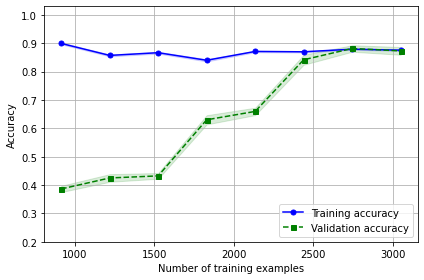


SVM:
---------------------
Best model score: 0.990
Best model params: {'svc__C': 10.0, 'svc__gamma': 10.0, 'svc__kernel': 'rbf'}


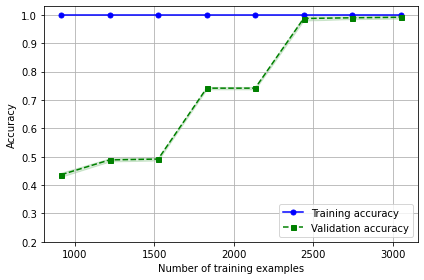


Decision Tree:
---------------------
Best model score: 0.968
Best model params: {'max_depth': None}


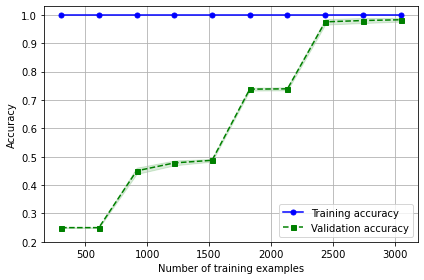


KNN:
---------------------
Best model score: 0.984
Best model params: {'kneighborsclassifier__n_neighbors': 1}


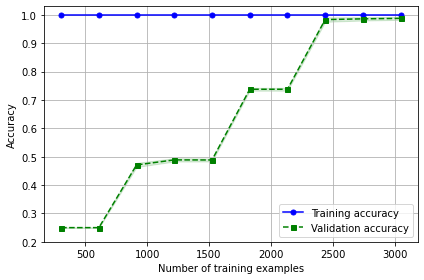

In [35]:
L = [pipe_lr, pipe_svc, tree_clf, pipe_knn]

clf_lr = None
clf_svm = None
clf_tree = None
clf_knn = None
clf_best = None

for clf in L:
    if clf == pipe_lr:
        print('\nLogistic Regression:\n---------------------')
        gs = GridSearchCV(estimator=pipe_lr,
                param_grid=[{'logisticregression__C':[0.01, 0.1, 1, 10]}],
                scoring='accuracy',
                cv=2,
                n_jobs=-1)
        gs = gs.fit(X_train_lda, y_train)
        clf_best = gs.best_estimator_
        clf_lr = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_svc:
        print('\nSVM:\n---------------------')
        gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
        gs = gs.fit(X_train_lda, y_train)
        clf_best = gs.best_estimator_
        clf_svm = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == tree_clf:
        print('\nDecision Tree:\n---------------------')
        gs = GridSearchCV(estimator=tree_clf,
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train_lda_no_std, y_train)
        clf_best = gs.best_estimator_
        clf_tree = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
    elif clf == pipe_knn:
        print('\nKNN:\n---------------------')
        gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': param_range_knn}],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
        gs = gs.fit(X_train_lda, y_train)
        clf_best = gs.best_estimator_
        clf_knn = gs.best_estimator_
        print(f'Best model score: {gs.best_score_:.3f}')
        print(f'Best model params: {gs.best_params_}')
        
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf_best,
                                X=X_train_lda,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=-1)
    # since decision tree NO need standardization!
    if clf == tree_clf:
        train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf_best,
                                X=X_train_lda_no_std,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=-1)
        

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='Training accuracy')

    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='Validation accuracy')

    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.2, 1.03])
    plt.tight_layout()
    # plt.savefig('images/06_05.png', dpi=300)
    plt.show()

### <font color="purple">So, I finally select KNN as my model.<font>

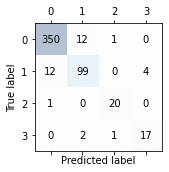

In [36]:
from sklearn.metrics import confusion_matrix

# Select knn
clf_knn.fit(X_train_lda, y_train)
y_pred = clf_knn.predict(X_test_lda)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

Accuracy: 0.936
Precision: 0.890
Recall: 0.907
F1: 0.898


### Discussion

本小題著重在feature selection or extraction，也就是說目標是在不要犧牲太多效能的情況下，去大幅降低運算量<br>
因為feature selection的結果極度不理想，因此第一階段就將其捨棄了<br>
主要以PCA和LDA這兩個feature extraction method來做比較<br>

下表則是validation的各項指標整理 (PCA)

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
CV Accuracy    | 0.710 +/- 0.018                  | 0.981 +/- 0.007 |   0.937 +/- 0.010       | 0.946 +/- 0.006|
f1_score    |0.711 +/- 0.019                      | 0.981 +/- 0.007 |   0.936 +/- 0.010     | 0.946 +/- 0.006|
Precision    |  0.712 +/- 0.021                      | 0.983 +/- 0.006 |   0.941 +/- 0.010     | 0.949 +/- 0.006| 

下表則是validation的各項指標整理 (LDA)

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
CV Accuracy    | 0.872 +/- 0.010                      | 0.989 +/- 0.006|   0.984 +/- 0.005       | 0.987 +/- 0.005|
f1_score    |0.870 +/- 0.010                         | 0.989 +/- 0.006 |   0.984 +/- 0.005     | 0.987 +/- 0.005 |
Precision    |  0.871 +/- 0.011                     | 0.989 +/- 0.006 |   0.984 +/- 0.005       | 0.988 +/- 0.005 | 

由上面兩張表格可以發現到LDA整體表現好於PCA，而這結果似乎也是可猜測的，因為LDA相對於PCA保留了更多label的資訊，在分類上自然有機會能分得更好<br>
單看表格，可以說選擇SVM做為拿來評估的model較合適，但為了觀察overfitting的狀況，再加入learning curve來探討<br>
首先，logistic regression在training accuracy表現就不如其他演算法，而剩餘三者演算法在learning curve上在最後的表現都是不錯的，training和validation有收斂到一起，代表overfitting現象並不明顯，而若要仔細看的話會發現decision tree的差距稍微大一點點，但並不明顯，而SVM跟KNN差距極小，因此還無法由此兩者選出model來apply test set評估<br>
於是，下一步就決定在grid search找出最佳參數後再用best score來權衡<br><br>
下表為best score的整理<br>

Algorithms |  Logistic Regression | SVM  | Decision Tree | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------------:|
Best_model_score    |       0.878              | 0.990|   0.968       |0.984 |

因此，根據上表結果，儘管SVM看起來score較高，但回歸到為了減少運算量的原意，選擇KNN可能是較合適的，故我**最終選擇KNN(n_neighbors=1)作為model來評估** 

綜合上述結果，以下將藉由幾項指標搭配confusion matrix，對我使用的演算法(KNN)來探討model的performance<br>

Algorithms |  KNN | 
--------------|:----------------------------:|
Accuracy    | 93.6%                         |
Precision    | 89.0%                |
Recall   | 90.7%                       |
f1_score    | 89.8%                  |    

根據confusion matrix的結果，可以發現到扣除對角線的左下區和右上區，這兩區分別的個數比前一題來得多(> 10個)，而這兩區的總個數差不多，代表說計算precision和recall的時候值會很接近<br>
再根據上表可以發現accuracy最高，總體有93.6%的準度，相較於前一題下降了約5%，但使用LDA可以讓維度降到只剩3維(相較於原本的6種features, 6維)減少了不少，而準度僅影響5%是還算不錯的結果；再看到precision和recall的值，與前一題類似，recall稍高一點點，代表說我的model是相對寬鬆的，儘管有時候會誤判，但較不會有漏掉沒抓到的情形。<br>
但整體來說兩者有接近90%的值，且最後一項指標f1_score來綜觀這個model，具有89.8%，因此我認為在LDA的影響下，表現已經算是十分不錯！<br>

從computational complexity的角度來討論，本題利用LDA來減少運算量，同時又能不太影響performance，我認為可說是達到了前一題discussion所提的概念，**利用些許效能犧牲，換取運算量減少較多**<br>
除此之外，由於我最後使用的model是KNN，而不像前面使用RBF kernel的SVM，理由是RBF kernel SVM無論是training的耗時、運算的complexity都比較複雜，而這題KNN能夠做到接近甚至有可能更好的performance，因此最後選擇使用KNN<br>

實際training的時間上，與前面類似，在grid search SVM的時候會耗費最長時間，原因應該是SVM本身可調的參數就多(kernel, C, gamma)；而相對來說，KNN和decision tree所花費的時間較短，而這兩者相差並不大，主要花的時間應該跟neighbors個數(KNN), max_depth(decision tree)有極大關聯<br>
但是，與第2題比較的話，training時可以感受到本題所耗的時間較少，推測應該是LDA造成的降維效果，使得model在建立的時候不需要花如同第2題那樣龐大的運算資源！

### Conclusion

以下把三個小題個別最後的分數列出，方便觀察<br>
<center><strong>第1題 (2 labels, all features)</strong>

Algorithms |  SVM(Kernel RBF) | 
--------------|:----------------------------:|
Accuracy    | 99.6%                         |
Precision    | 97.5%                |
Recall   | 97.5%                       |
f1_score    | 97.5%                  |    

<center><strong>第2題 (4 labels, all features)</strong>
    
Algorithms |  SVM(Kernel RBF) | 
--------------|:----------------------------:|
Accuracy    | 98.8%                         |
Precision    | 95.9%                |
Recall   | 97.0%                       |
f1_score    | 96.4%                  |    

<center><strong>第3題 (4 labels, not all features)</strong>

Algorithms |  KNN | 
--------------|:----------------------------:|
Accuracy    | 93.6%                         |
Precision    | 89.0%                |
Recall   | 90.7%                       |
f1_score    | 89.8%                  |    

簡單來看，2 label的會較好分類，因此容易分到最佳；而4 labels時，就取決於資源用量，如果不考慮運算量多寡追求效能極致，則使用all features的model，可以得到和2 label接近的水準，但若犧牲些許效能來減低運算量跟computational complexity的話，則選擇not all features的model更合適<br>
這次作業實作上有遇到一些要注意的地方，像是resample時是對training set去，而不是對整個dataset取完後再resample；還有若要畫出ROC AUC curve，要記得將model的probability參數設定為True (如果model本身輸出非機率的話，像是SVM)，希望之後的作業不會再遇到類似的狀況了！

總結，藉由這次作業，可以讓我們更加熟悉sklearn套件的操作方式，並學習如何用不同的metric來評估model，像是confusion matrix, ROC AUC curve這些參數都是以後在做作業或是final project有可能大量使用的，做完這次作業後希望能夠熟悉並掌握這些特性！<br>